# Import Libraries

In [1]:
import pandas as pd
import zipfile
import os
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Preprocessing / Pipeline / Decomposition libraries
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn import set_config

# Model Selection / Grid Search libraries
from sklearn.model_selection import cross_val_predict, train_test_split, KFold
from sklearn.model_selection import GridSearchCV

# ML models 
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

os.getcwd()

'/Users/domenicospoto/Desktop/Sapienza/MScDataScience/FundamentalsofDataScienceandLaboratory/FinalProject/FDS-FinalProject'

In [2]:
# extract file with zipfile
zip_df = zipfile.ZipFile('walmart-recruiting-store-sales-forecasting.zip')
zip_df.extractall()
zip_df.close()

# Exploratory Data Analysis

### Part 1: Data cleaning

In [2]:
# cols: Store, Dept, Date, Weekly_Sales, IsHoliday
train = pd.read_csv('train.csv.zip', compression='zip')
# cols: Store, Dept, Date, IsHoliday
test = pd.read_csv('test.csv.zip', compression='zip')
# cols: Store, Date, Temperature, Fuel_Price, MarkDown1 - 5, CPI, Unemployment, IsHoliday
features = pd.read_csv('features.csv.zip', compression='zip')
# cols: Store, Type, Size
stores = pd.read_csv('stores.csv')
# cols: Id, Weekly_Sales
sample_submission = pd.read_csv('sampleSubmission.csv.zip', compression='zip')

In this section we print the information on "train", "features", "stores" and "test datasets.

In [3]:
print(pd.DataFrame(train.dtypes, columns=['Type']))
train

                 Type
Store           int64
Dept            int64
Date           object
Weekly_Sales  float64
IsHoliday        bool


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [4]:
print(pd.DataFrame(features.dtypes, columns=['Type']))
features.head()

                 Type
Store           int64
Date           object
Temperature   float64
Fuel_Price    float64
MarkDown1     float64
MarkDown2     float64
MarkDown3     float64
MarkDown4     float64
MarkDown5     float64
CPI           float64
Unemployment  float64
IsHoliday        bool


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [5]:
print(pd.DataFrame(stores.dtypes, columns=['Type']))
stores.head()

         Type
Store   int64
Type   object
Size    int64


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [6]:
print(pd.DataFrame(test.dtypes, columns=['Type']))
test

             Type
Store       int64
Dept        int64
Date       object
IsHoliday    bool


,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False
...,...,...,...,...
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False


In [7]:
print(pd.DataFrame(sample_submission.dtypes, columns=['Type']))
sample_submission

                Type
Id            object
Weekly_Sales   int64


,Id,Weekly_Sales
0,1_1_2012-11-02,0
1,1_1_2012-11-09,0
2,1_1_2012-11-16,0
3,1_1_2012-11-23,0
4,1_1_2012-11-30,0
...,...,...
115059,45_98_2013-06-28,0
115060,45_98_2013-07-05,0
115061,45_98_2013-07-12,0
115062,45_98_2013-07-19,0


In [8]:
# shapes of files
print(train.shape)
print(test.shape)
print(features.shape)
print(stores.shape)
print(sample_submission.shape)

(421570, 5)
(115064, 4)
(8190, 12)
(45, 3)
(115064, 2)


As we can see, the column 'Date' in train, features and test is a string type of data. We can convert it to datetime.

In [9]:
train['Date'] = pd.to_datetime(train['Date'])
features['Date'] = pd.to_datetime(features['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [10]:
print(pd.DataFrame({'type': [train['Date'].dtypes,features['Date'].dtypes,test['Date'].dtypes]}, 
                    index=['train', 'features', 'test']))

                    type
train     datetime64[ns]
features  datetime64[ns]
test      datetime64[ns]


Now, we can merge the datasets.

In [11]:
# merge the features with the stores dataset
new_features = pd.merge(features, stores, on=['Store'])
print(pd.DataFrame(new_features.dtypes, columns=['Type'])) # types of new dataframe
new_features.head()

                        Type
Store                  int64
Date          datetime64[ns]
Temperature          float64
Fuel_Price           float64
MarkDown1            float64
MarkDown2            float64
MarkDown3            float64
MarkDown4            float64
MarkDown5            float64
CPI                  float64
Unemployment         float64
IsHoliday               bool
Type                  object
Size                   int64


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [12]:
# merge the train with the new features dataset
df_train = pd.merge(train, new_features, on=['Store', 'Date', 'IsHoliday'], how='left')
print(pd.DataFrame(df_train.dtypes, columns=['Type'])) # types of new dataframe
df_train

                        Type
Store                  int64
Dept                   int64
Date          datetime64[ns]
Weekly_Sales         float64
IsHoliday               bool
Temperature          float64
Fuel_Price           float64
MarkDown1            float64
MarkDown2            float64
MarkDown3            float64
MarkDown4            float64
MarkDown5            float64
CPI                  float64
Unemployment         float64
Type                  object
Size                   int64


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,B,118221
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,B,118221
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,B,118221


In [13]:
# merge the test with the new features dataset
df_test = pd.merge(test, new_features, on=['Store', 'Date', 'IsHoliday'], how='left')
print(pd.DataFrame(df_test.dtypes, columns=['Type'])) # types of new dataframe
df_test

                        Type
Store                  int64
Dept                   int64
Date          datetime64[ns]
IsHoliday               bool
Temperature          float64
Fuel_Price           float64
MarkDown1            float64
MarkDown2            float64
MarkDown3            float64
MarkDown4            float64
MarkDown5            float64
CPI                  float64
Unemployment         float64
Type                  object
Size                   int64


,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315
1,1,1,2012-11-09,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,A,151315
2,1,1,2012-11-16,False,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,A,151315
3,1,1,2012-11-23,True,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,A,151315
4,1,1,2012-11-30,False,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,98,2013-06-28,False,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,B,118221
115060,45,98,2013-07-05,False,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,B,118221
115061,45,98,2013-07-12,False,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,B,118221
115062,45,98,2013-07-19,False,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,B,118221


Here, we can check how many Nan values we have in the dataset.

In [14]:
# get all Nan values in train dataset and their percentages
df_nan = pd.concat([df_train.isna().sum(), round(df_train.isna().sum()/len(df_train)*100, 4)], axis=1)\
                .rename(columns={0: '# nan', 1: '% nan'}).sort_values(ascending=False, by=['% nan'])
df_nan = df_nan[df_nan['% nan']!=0]
df_nan

,# nan,% nan
MarkDown2,310322,73.6110
MarkDown4,286603,67.9847
MarkDown3,284479,67.4808
MarkDown1,270889,64.2572
MarkDown5,270138,64.0790


In [15]:
# get all Nan values in train dataset and their percentages
df_nan_test = pd.concat([df_test.isna().sum(), round(df_test.isna().sum()/len(df_test)*100, 4)], axis=1)\
                .rename(columns={0: '# nan', 1: '% nan'}).sort_values(ascending=False, by=['% nan'])
df_nan_test = df_nan_test[df_nan_test['% nan']!=0]
df_nan_test

,# nan,% nan
CPI,38162,33.1659
Unemployment,38162,33.1659
MarkDown2,28627,24.8792
MarkDown4,12888,11.2007
MarkDown3,9829,8.5422
MarkDown1,149,0.1295


The only columns with Nan values are the markdown ones with more than 60 % of them.

In [16]:
df_train.drop(columns=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], inplace=True)
df_test.drop(columns=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], inplace=True)
df_train

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,211.350143,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,192.013558,8.684,B,118221
421566,45,98,2012-10-05,628.10,False,64.89,3.985,192.170412,8.667,B,118221
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,192.327265,8.667,B,118221
421568,45,98,2012-10-19,760.01,False,56.47,3.969,192.330854,8.667,B,118221


We decided to drop 'Markdown 1' to 'Markdown 5' because they have a lot of null values (> than 60% in all of them).

### Part 2: Holiday Analysis

In [17]:
# add columns to select week and year from date
df_train['week'] = df_train['Date'].dt.week
df_train['year'] = df_train['Date'].dt.year
df_test['week'] = df_test['Date'].dt.week
df_test['year'] = df_test['Date'].dt.year
# KEEPING THE COLUMN 'DATE', MAYBE WE CAN REMOVE IT AFTERWORDS

In [18]:
df_train_holiday = df_train[df_train['IsHoliday'] == True]
df_test_holiday = df_test[df_test['IsHoliday'] == True]
df_train_holiday

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,week,year
1,1,1,2010-02-12,46039.49,True,38.51,2.548,211.242170,8.106,A,151315,6,2010
31,1,1,2010-09-10,18194.74,True,78.69,2.565,211.495190,7.787,A,151315,36,2010
42,1,1,2010-11-26,18820.29,True,64.52,2.735,211.748433,7.838,A,151315,47,2010
47,1,1,2010-12-31,19124.58,True,48.43,2.943,211.404932,7.838,A,151315,52,2010
53,1,1,2011-02-11,37887.17,True,36.39,3.022,212.936705,7.742,A,151315,6,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...
421510,45,98,2011-09-09,1092.66,True,71.48,3.738,186.673738,8.625,B,118221,36,2011
421521,45,98,2011-11-25,794.62,True,48.71,3.492,188.350400,8.523,B,118221,47,2011
421526,45,98,2011-12-30,553.21,True,37.79,3.389,189.062016,8.523,B,118221,52,2011
421532,45,98,2012-02-10,770.86,True,37.00,3.640,189.707605,8.424,B,118221,6,2012


We consider the fact that the Super Bowl happens five months after the Labour Day so on the 6th week of each year, the Labour Day happens on the first Monday of September (on the 36th week of each year), the Thanksgiving happens the fourth Thursday of November (on the 47th week of each year) and Christmas happens on the 25th day each year.

In [19]:
Year = []
Week = []
Data_type = []
Holiday = []
Day = []
for i in df_train_holiday['Date'].unique():
    Week.append(int(df_train_holiday.set_index('Date').loc[i, 'week'].unique()))
    Year.append(int(df_train_holiday.set_index('Date').loc[i, 'year'].unique()))
    Data_type.append('Train data')
    if df_train_holiday.set_index('Date').loc[i, 'week'].unique() == 6:
        Holiday.append('Super Bowl')
    elif df_train_holiday.set_index('Date').loc[i, 'week'].unique() == 36:
        Holiday.append('Labour Day')
    elif df_train_holiday.set_index('Date').loc[i, 'week'].unique() == 47:
        Holiday.append('Thanksgiving')
    else:
        Holiday.append('Christmas')

for i in df_test_holiday['Date'].unique():
    Week.append(int(df_test_holiday.set_index('Date').loc[i, 'week'].unique()))
    Year.append(int(df_test_holiday.set_index('Date').loc[i, 'year'].unique()))
    Data_type.append('Test data')
    if df_test_holiday.set_index('Date').loc[i, 'week'].unique() == 6:
        Holiday.append('Super Bowl')
    elif df_test_holiday.set_index('Date').loc[i, 'week'].unique() == 36:
        Holiday.append('Labour Day')
    elif df_test_holiday.set_index('Date').loc[i, 'week'].unique() == 47:
        Holiday.append('Thanksgiving')
    else:
        Holiday.append('Christmas')

table = pd.DataFrame({'Year': Year, 'Week': Week,
                  'Data_type': Data_type, 'Holiday': Holiday})
table

,Year,Week,Data_type,Holiday
0,2010,6,Train data,Super Bowl
1,2010,36,Train data,Labour Day
2,2010,47,Train data,Thanksgiving
3,2010,52,Train data,Christmas
4,2011,6,Train data,Super Bowl
5,2011,36,Train data,Labour Day
6,2011,47,Train data,Thanksgiving
7,2011,52,Train data,Christmas
8,2012,6,Train data,Super Bowl
9,2012,36,Train data,Labour Day


We can see that in the Test dataset there is no 'Labour Day', so this holiday is not relevant.

Here, we compute the Average Weekly Sales per Year and see if there are week holidays that we are not considering.

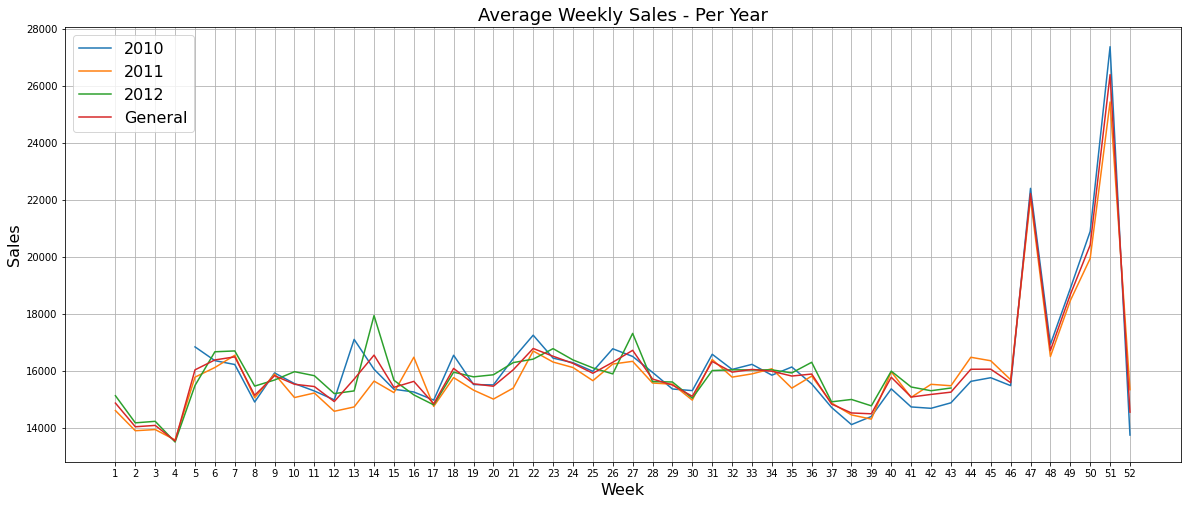

In [20]:
weekly_sales_2010 = df_train[df_train.year==2010]['Weekly_Sales'].groupby(df_train['week']).mean()
weekly_sales_2011 = df_train[df_train.year==2011]['Weekly_Sales'].groupby(df_train['week']).mean()
weekly_sales_2012 = df_train[df_train.year==2012]['Weekly_Sales'].groupby(df_train['week']).mean()
weekly_sales_general = df_train['Weekly_Sales'].groupby(df_train['week']).mean()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)
sns.lineplot(weekly_sales_general.index, weekly_sales_general.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012','General'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()

We may see that there is a peak between the 13th and the 14th week each year and it is Easter Day.
    
    - In 2010 is in week 13
    - In 2011 is in week 16
    - In 2012 is in week 14
 
Now we can change the 'IsHoliday' feature to True.

In [21]:
df_train.loc[(df_train['year'] == 2010) & (df_train['week'] == 13), 'IsHoliday'] = True #2010
df_train.loc[(df_train['year'] == 2011) & (df_train['week'] == 16), 'IsHoliday'] = True #2011
df_train.loc[(df_train['year'] == 2012) & (df_train['week'] == 14), 'IsHoliday'] = True #2012

Here, we show the Mean and Median of the Weekly Sales for all the years together.

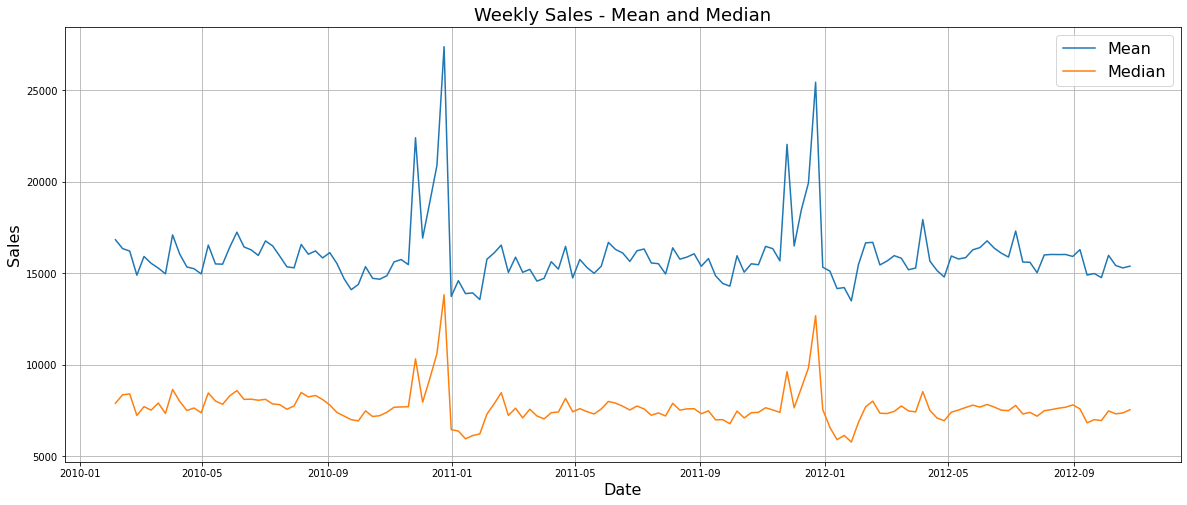

In [22]:
weekly_sales_mean = df_train['Weekly_Sales'].groupby(df_train['Date']).mean()
weekly_sales_median = df_train['Weekly_Sales'].groupby(df_train['Date']).median()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_mean.index, weekly_sales_mean.values)
sns.lineplot(weekly_sales_median.index, weekly_sales_median.values)
plt.grid()
plt.legend(['Mean', 'Median'], loc='best', fontsize=16)
plt.title('Weekly Sales - Mean and Median', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

From this graph we can see that there are some stores/depts that sell much more items than the others because the mean is higher compared to the median. Moreover, it seems there is a sort of cyclicality during the last two months of each year.

### Part 3: Weekly Sales Analysis

We show the Average Sales per Store.

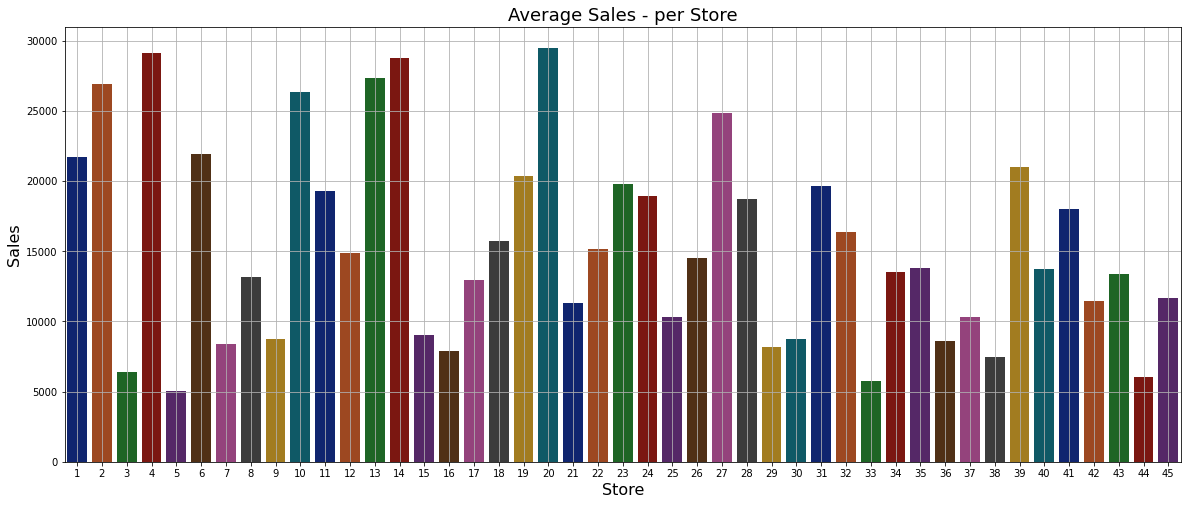

In [23]:
weekly_sales_store = df_train['Weekly_Sales'].groupby(df_train['Store']).mean()
plt.figure(figsize=(20,8))
sns.barplot(weekly_sales_store.index, weekly_sales_store.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

The graph confirms there are some stores that have an average sales higher than others.

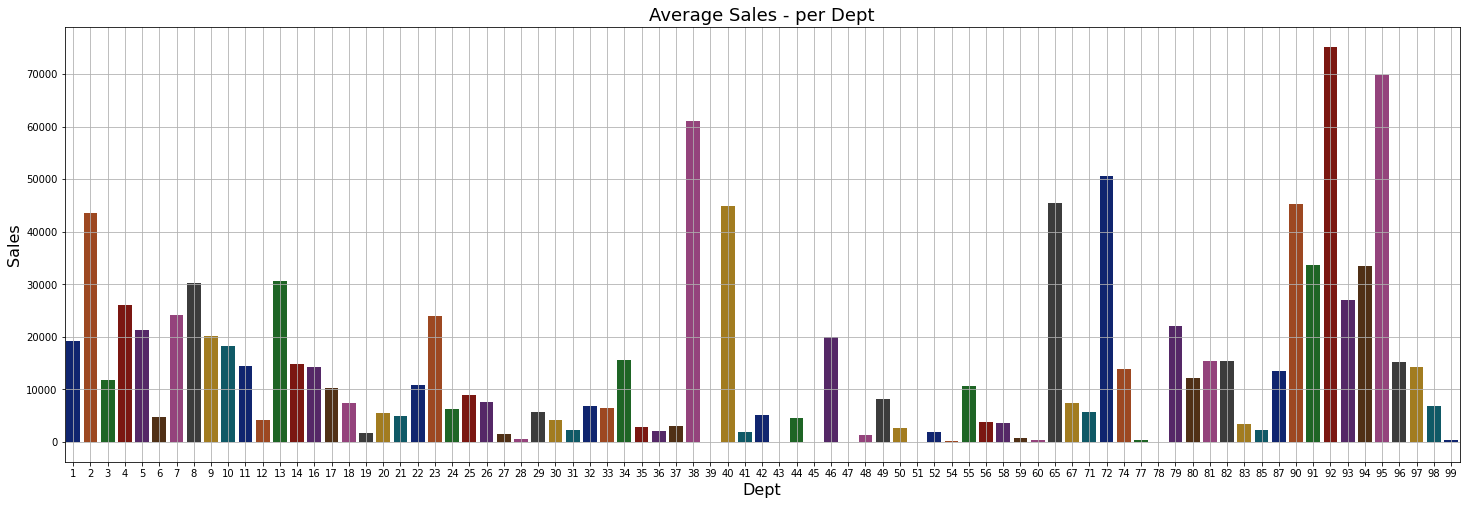

In [24]:
weekly_sales_dept = df_train['Weekly_Sales'].groupby(df_train['Dept']).mean()
plt.figure(figsize=(25,8))
sns.barplot(weekly_sales_dept.index, weekly_sales_dept.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Dept', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Dept', fontsize=16)
plt.show()

The graph above confirms also there are departments that sell much more than others.

Moreover, we can see there are missing depts such as the dept '15' and between 61 and 64.

### Part 4: Correlation Analysis

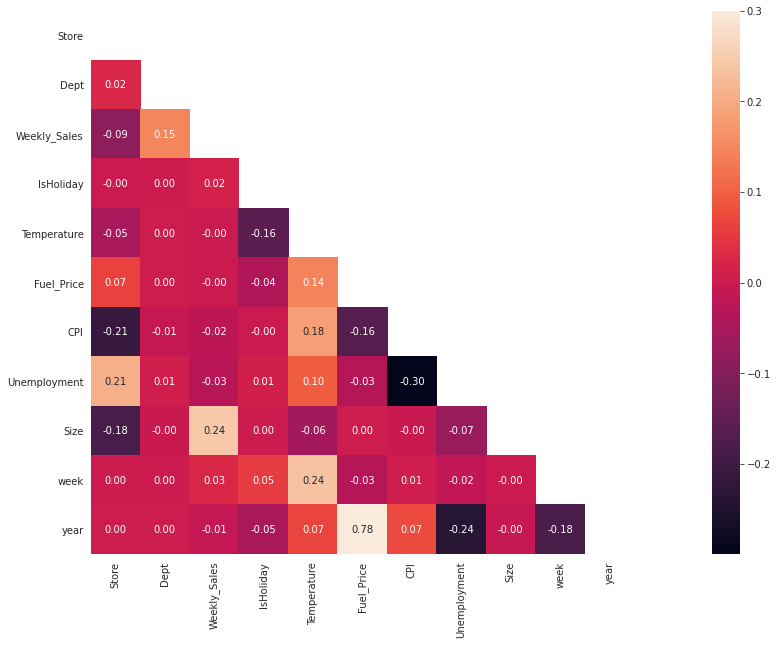

In [25]:
corr = df_train.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(28, 10))
    ax = sns.heatmap(corr, annot=True, fmt='.2f', mask=mask, vmax=.3, square=True)

From the correlation analysis we can see there is not a strong correlation between the 'Weekly_sales' dependent variable and the independent variables. The only one with a mild correlation is 'Size'.

### Part 5: Analysing Variables

In [26]:
df_train.drop(['week', 'year'], axis=1, inplace=True)
df_test.drop(['week', 'year'], axis=1, inplace=True)

In [27]:
from matplotlib.gridspec import GridSpec
def make_scatterplot(df):
    fig = plt.figure(figsize=(18,15))
    gs = GridSpec(4,2)
    l = sns.scatterplot(y='Weekly_Sales', 
                x='Temperature', hue='IsHoliday', data=df, ax=fig.add_subplot(gs[0,0]))
    l = sns.scatterplot(y='Weekly_Sales', 
                x='Fuel_Price', hue='IsHoliday', data=df, ax=fig.add_subplot(gs[0,1]))
    l = sns.scatterplot(y='Weekly_Sales', 
                x='CPI', hue='IsHoliday', data=df, ax=fig.add_subplot(gs[1,0]))
    l = sns.scatterplot(y='Weekly_Sales', 
                x='Unemployment', hue='IsHoliday', data=df, ax=fig.add_subplot(gs[1,1]))
    l = sns.scatterplot(y='Weekly_Sales', 
                x='Type', hue='IsHoliday', data=df, ax=fig.add_subplot(gs[2,0]))
    l = sns.scatterplot(y='Weekly_Sales', 
                x='Size', hue='IsHoliday', data=df, ax=fig.add_subplot(gs[2,1]))
#    l = sns.scatterplot(y='Weekly_Sales', 
#                x='HolidayType', hue='IsHoliday', data=df, ax=fig.add_subplot(gs[3,0]))
    
    fig.show()

/Users/domenicospoto/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


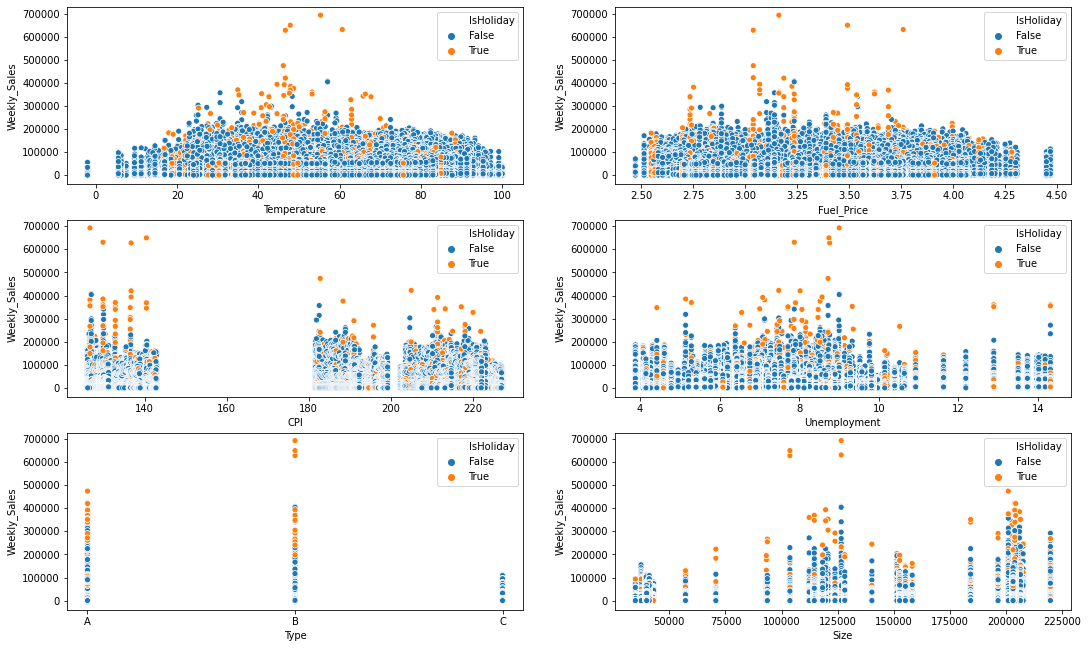

In [28]:
make_scatterplot(df_train)

As shown above, there is not a linear relationship between the indipendent variables under consideration and the dipendent variables. Therefore, we cannot infer any helpful relationships between 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment' and 'Weekly_Sales'.
However, in the varible 'Type' we can infer that the number 2 (corresponding to type B) and the number 3 (corresponding to type A) contains the highest weekly sales during the holiday dates.
Finally, we can infer there is a sort of relationship between 'Size' and 'Weekly_Sales' since higher is the size and higher are the weekle sale.

In [29]:
df_train.drop(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment'], axis=1, inplace=True)
df_test.drop(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment'], axis=1, inplace=True)
df_train

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315
...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,B,118221
421566,45,98,2012-10-05,628.10,False,B,118221
421567,45,98,2012-10-12,1061.02,False,B,118221
421568,45,98,2012-10-19,760.01,False,B,118221


# Machine Learning Models

In [30]:
# make copy of df_train and df_test
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

In [31]:
# transform Type from categorical to numerical value
df_train.Type = df_train.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))
df_test.Type = df_test.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,3,151315
1,1,1,2010-02-12,46039.49,True,3,151315
2,1,1,2010-02-19,41595.55,False,3,151315
3,1,1,2010-02-26,19403.54,False,3,151315
4,1,1,2010-03-05,21827.90,False,3,151315


In [32]:
def create_features(df):
    """
    This function creates the following features: Week, Month, Year and
    HolidayType
    """
    def create_holiday_type_column(df, dates, holiday_type, name):
        df.loc[
            df['Date'].isin(dates),
            'HolidayType'
        ] = holiday_type

    df['HolidayType'] = -1
    
    holiday_list = [
        (['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08'], 'Super_Bowl'),
        (['2010-09-10','2011-09-09', '2012-09-07', '2013-09-06'], 'Labor_Day'),
        (['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'], 'Thanksgiving'),
        (['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'], 'Christmas'),
        (['2010-04-02', '2011-04-08','2012-04-06','2013-03-29'], 'Easter')
    ]
    
    for index in range(0, len(holiday_list)):
        holiday = holiday_list[index]
        create_holiday_type_column(df, holiday[0], index, holiday[1])
    
    df.Date = pd.to_datetime(df.Date)
    df['Week'] = df.Date.dt.week
    df['Year'] =  df.Date.dt.year
    df['Month'] =  df.Date.dt.month
    
    # Convert all columns to float
    for x in df:
        if df[x].dtypes == "int64":
            df[x] = df[x].astype(float)

In [33]:
create_features(df_train)

In [34]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,HolidayType,Week,Year,Month
0,1.0,1.0,2010-02-05,24924.50,False,3.0,151315.0,-1.0,5.0,2010.0,2.0
1,1.0,1.0,2010-02-12,46039.49,True,3.0,151315.0,0.0,6.0,2010.0,2.0
2,1.0,1.0,2010-02-19,41595.55,False,3.0,151315.0,-1.0,7.0,2010.0,2.0
3,1.0,1.0,2010-02-26,19403.54,False,3.0,151315.0,-1.0,8.0,2010.0,2.0
4,1.0,1.0,2010-03-05,21827.90,False,3.0,151315.0,-1.0,9.0,2010.0,3.0


In [35]:
X = df_train.drop(columns=['Date', 'Weekly_Sales'], axis=1)
X.head()

,Store,Dept,IsHoliday,Type,Size,HolidayType,Week,Year,Month
0,1.0,1.0,False,3.0,151315.0,-1.0,5.0,2010.0,2.0
1,1.0,1.0,True,3.0,151315.0,0.0,6.0,2010.0,2.0
2,1.0,1.0,False,3.0,151315.0,-1.0,7.0,2010.0,2.0
3,1.0,1.0,False,3.0,151315.0,-1.0,8.0,2010.0,2.0
4,1.0,1.0,False,3.0,151315.0,-1.0,9.0,2010.0,3.0


In [36]:
Y = df_train['Weekly_Sales']
Y.head()

0    24924.50
1    46039.49
2    41595.55
3    19403.54
4    21827.90
Name: Weekly_Sales, dtype: float64

In [37]:
# check that all the columns are numerics
numeric_features = X.columns[X.dtypes == 'float64' ]
for col in numeric_features:
    print(col)

Store
Dept
Type
Size
HolidayType
Week
Year
Month


### Part 1: Find the best model type

In [38]:
def WMAE(dataset, real, predicted):
    """
    Implementation of competition evaluation metric
    """
    weights = dataset.HolidayType.apply(lambda x: 5 if x>=0 else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

def plot_regression_results(y_true, y_pred, title, scores):
    """
    Scatter plot of the predicted vs true targets
    """
    ax = plt.gca()
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc='w', fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title
    ax.set_title(title)
    plt.show()

In [39]:
# Divide dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [40]:
import math 
regression_models = [
    'LinearRegression',
    'KNN',
    'Ridge',
    'Lasso',
    'RandomForestRegressor',
]

best_model = None
best_error = math.inf
#best_split = None

In [41]:
def model_factory(model_type, **kwargs): 
    """
    This function creates a model considering the model_type
    and specific arguments.
    """
    # Specific for RandomForestRegressor
    if model_type in ['RandomForestRegressor']:
        n_estimators = kwargs.get('n_estimators')    #The number of trees in the forest.
        #max_depth = kwargs.get('max_depth')         #The maximum depth of the tree. 
        #min_samples_split = kwargs.get('min_samples_split') #The minimum number of samples required to split an internal node
        #max_features = kwargs.get('max_features')   #The number of features to consider when looking for the best split
        verbose = kwargs.get('verbose')
        n_jobs = kwargs.get('n_jobs')

        if n_estimators is None:   
            n_estimators = 50

        verbose = 0 if verbose is None else verbose

    if model_type == 'LinearRegression':
        return LinearRegression()
    elif model_type == 'KNN':
        return KNeighborsRegressor()
    elif model_type == 'Ridge':
        return RidgeCV()
    elif model_type == 'Lasso':
        return LassoCV()
    elif model_type == 'RandomForestRegressor':
        return RandomForestRegressor(
            n_estimators = n_estimators,
            #max_depth = max_depth,
            #min_samples_split = min_samples_split,
            #max_features = max_features,
            #min_samples_leaf = num_leafs,
            verbose = verbose,
            n_jobs = n_jobs
        )
    else:
        raise ValueError('Model not defined on factory.')

--------------------------------------------------
Training evaluation
--------------------------------------------------
:: LinearRegression - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished


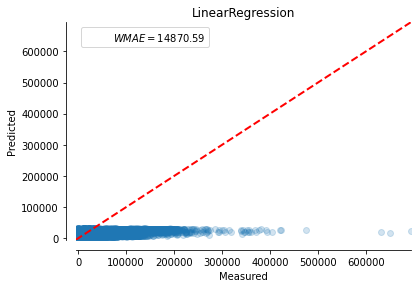

--------------------------------------------------
:: KNN - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.4s finished


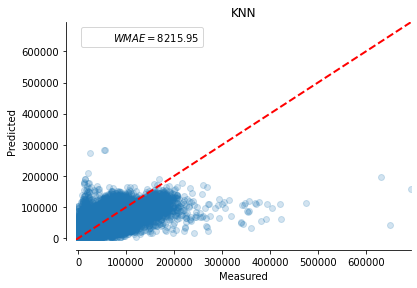

--------------------------------------------------
:: Ridge - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished


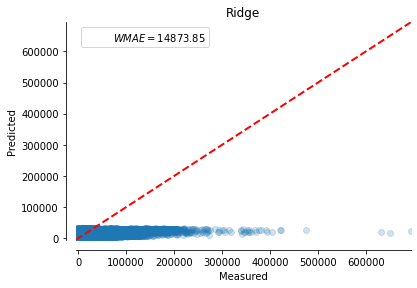

--------------------------------------------------
:: Lasso - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished


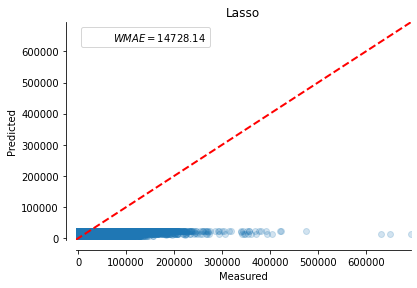

--------------------------------------------------
:: RandomForestRegressor - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   31.5s finished


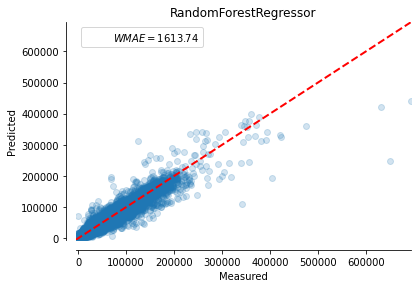

--------------------------------------------------


In [42]:
print('-' * 50)
print('Training evaluation')
print('-' * 50)

for name in regression_models:
    # Create a basic pipeline
    print(f':: {name} - Training Pipeline')
    regressor = model_factory(name)
    training_pipeline = make_pipeline(regressor)

    kfold = KFold(n_splits=3)

    y_pred = cross_val_predict(
        training_pipeline,
        X_train,
        y_train,
        cv = kfold,
        n_jobs = -1,
        verbose = 1)

    wmae_metric = WMAE(X_train, y_train, y_pred)

    if wmae_metric < best_error:
        best_error = wmae_metric
        best_model = name
        best_split = 3

    plot_regression_results(
        y_train,
        y_pred,
        name,
        (r'$WMAE ={:.2f}$').format(wmae_metric)
    )

    print('-' * 50)

In [43]:
print(f'Best model is {best_model}')
print(f'Best score is {best_error}')

Best model is RandomForestRegressor
Best score is 1613.74


### Part 2: Finding best hyperparameters

In [44]:
# the number of estimator
#n_estimators = range(50, 250, 50)
n_estimators = [100, 200]
# the max depth of each tree
max_depth = [19, 25, 30]
# the number of leafs in the forest
#num_leafs = [1, 5, 10, 20, 50, 100]
#The minimum number of samples required to split an internal node
min_samples_split = [2, 3, 4]
#The number of features to consider when looking for the best split
#max_features = [2, 3, 4, 5, 6, 7]


parameters = [{'n_estimators' : n_estimators,
                'max_depth' : max_depth,
                #'min_samples_leaf':num_leafs,
                'min_samples_split' : min_samples_split,
                #'max_features' : max_features,
             }]
def get_best_model_parameters(random_grid, X, Y):
    
    model = model_factory(best_model)
    
    kfold = KFold(n_splits=3)

    model_gs = GridSearchCV(
                      estimator=model,
                      param_grid=random_grid,
                      cv = kfold,
                      n_jobs = -1,
                      verbose = 1)
    
    # Create a sample to speed up parameter search
    X_sample, _, y_sample, _ = train_test_split(X, Y, test_size=0.9) 
    model_gs.fit(X_sample, y_sample)
    return model_gs.best_params_

# Best Parameter combination
best_params = get_best_model_parameters(parameters, X, Y)
best_params

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  2.4min finished


{'max_depth': 19, 'min_samples_split': 2, 'n_estimators': 200}

### Part 3: Training the Full Dataset

In [45]:
print('-' * 70)
print(f'Best Model: {best_model}: {best_params}\n')
#print('Tip: click on the Pipeline diagram below to have a better view of each step.')
print('-' * 70)

model = model_factory(
    best_model,
    n_estimators = best_params['n_estimators'],
    max_depth = best_params['max_depth'],
    #min_samples_leaf = best_params['min_samples_leaf'],
    min_samples_split = best_params['min_samples_split'],
    verbose = 1,
    n_jobs = -1)

model.fit(X_train, y_train)

----------------------------------------------------------------------
Best Model: RandomForestRegressor: {'max_depth': 19, 'min_samples_split': 2, 'n_estimators': 200}

----------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   49.0s finished


RandomForestRegressor(n_estimators=200, n_jobs=-1, verbose=1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    5.7s finished


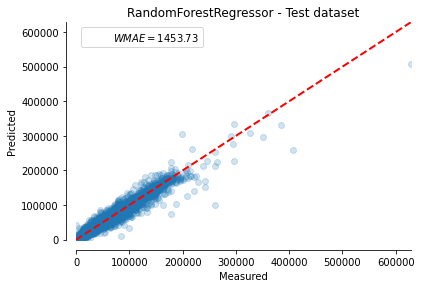

In [46]:
y_pred = model.predict(X_test)
wmae_metric = WMAE(X_test, y_test, y_pred)

plot_regression_results(
    y_test,
    y_pred,
    f'{best_model} - Test dataset',
    (r'$WMAE ={:.2f}$').format(wmae_metric)
)

In [47]:
def plot_features_importance(importance, names, model_type):
    """
    This function plots the model features importance 
    """
    feature_importance = np.array(importance)
    feature_names = np.array(names)


    data={'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10, 7))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(f'{model_type} - Feature Importance')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()

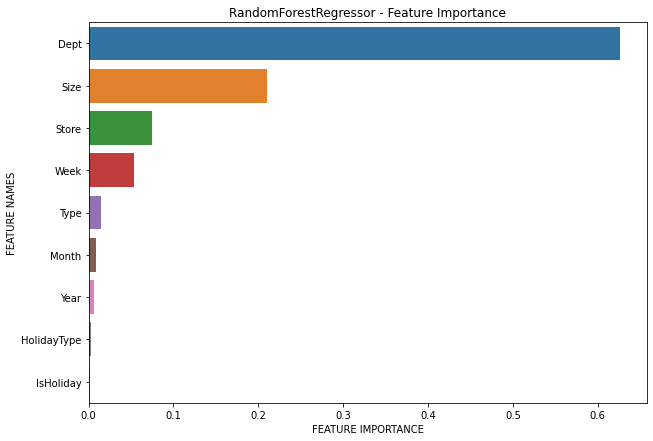

In [48]:
features_importance = model.feature_importances_
    
plot_features_importance(
    features_importance,
    X_test.columns,
    best_model)

In [54]:
# Creates df_test dataset
create_features(df_test)
df_test = df_test[list(X_train.columns)]
df_test.head()

,Store,Dept,IsHoliday,Type,Size,HolidayType,Week,Year,Month
0,1.0,1.0,False,3.0,151315.0,-1.0,44.0,2012.0,11.0
1,1.0,1.0,False,3.0,151315.0,-1.0,45.0,2012.0,11.0
2,1.0,1.0,False,3.0,151315.0,-1.0,46.0,2012.0,11.0
3,1.0,1.0,True,3.0,151315.0,2.0,47.0,2012.0,11.0
4,1.0,1.0,False,3.0,151315.0,-1.0,48.0,2012.0,11.0


In [55]:
df_train

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,HolidayType,Week,Year,Month
0,1.0,1.0,2010-02-05,24924.50,False,3.0,151315.0,-1.0,5.0,2010.0,2.0
1,1.0,1.0,2010-02-12,46039.49,True,3.0,151315.0,0.0,6.0,2010.0,2.0
2,1.0,1.0,2010-02-19,41595.55,False,3.0,151315.0,-1.0,7.0,2010.0,2.0
3,1.0,1.0,2010-02-26,19403.54,False,3.0,151315.0,-1.0,8.0,2010.0,2.0
4,1.0,1.0,2010-03-05,21827.90,False,3.0,151315.0,-1.0,9.0,2010.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
421565,45.0,98.0,2012-09-28,508.37,False,2.0,118221.0,-1.0,39.0,2012.0,9.0
421566,45.0,98.0,2012-10-05,628.10,False,2.0,118221.0,-1.0,40.0,2012.0,10.0
421567,45.0,98.0,2012-10-12,1061.02,False,2.0,118221.0,-1.0,41.0,2012.0,10.0
421568,45.0,98.0,2012-10-19,760.01,False,2.0,118221.0,-1.0,42.0,2012.0,10.0


In [56]:
y_pred = model.predict(df_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    4.2s finished


In [67]:
def graph_relation_to_weekly_sale(col_relation, df, x='Week', palette=None):
    """
    This function plots the graph relation between 
    a categorized feature and the Weekly_Sales
    """
    #df.Date = pd.to_datetime(df.Date)
    #df['Week'] = df.Date.dt.week
    #df['Month'] = df.Date.dt.month
    #df['Year'] = df.Date.dt.year
    
    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    sns.lineplot(
        x=x,
        y='Weekly_Sales',
        hue=col_relation,
        data=df,
        #kind='line',
        height=5,
        aspect=2,
        palette=palette
    )
    plt.grid()
    plt.show()

In [74]:
df_test['Weekly_Sales'] = y_pred
df_test['DatasetType'] = 'Predicted'
df_test['Date'] = test['Date'].values # we dropped this column earlier

df_train['DatasetType'] = 'Actual'
df_train['Date'] = train['Date'].values # we dropped this column earlier

df_result = df_train.append(df_test)

graph_relation_to_weekly_sale('DatasetType', df_result, x='Date')

TypeError: object of type <class 'float'> cannot be safely interpreted as an integer.

In [75]:
sample_submission['Weekly_Sales'] = y_pred
sample_submission.to_csv('submission.csv',index=False)